<a href="https://colab.research.google.com/github/ryanas97/ml/blob/master/FinalAssignment/ML_Final_(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library.

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, SimpleRNN
from keras.models import Model
from nltk.translate.bleu_score import corpus_bleu


Using TensorFlow backend.


In [0]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  gru_weights.h5  lstm_weights.h5	sample_data


### Pre-process Dataset

In [4]:
line= pd.read_table('/content/drive/My Drive/de.txt', names=['deu'], nrows=19250, skip_blank_lines=False)
line2= pd.read_table('/content/drive/My Drive/en.txt', names=['en'], nrows=19250, skip_blank_lines=False)
# print(line[::-1])
# print(lines[::-1])
linesx = pd.concat([line, line2], axis=1)
lines = pd.concat([linesx, linesx])  
print(lines[::])

                                                     deu                                                 en
0      SAN FRANCISCO – Es war noch nie leicht, ein ra...  SAN FRANCISCO – It has never been easy to have...
1      In letzter Zeit allerdings ist dies schwierige...  Lately, with gold prices up more than 300% ove...
2      Erst letzten Dezember verfassten meine Kollege...  Just last December, fellow economists Martin F...
3                      Und es kam, wie es kommen musste.                              Wouldn’t you know it?
4      Seit der Veröffentlichung ihrer Artikel ist de...  Since their articles appeared, the price of go...
5      Jüngst erreichte er sogar ein Rekordhoch von 1...  Gold prices even hit a record-high $1,300 rece...
6      Im letzten Dezember argumentierten die Goldbug...  Last December, many gold bugs were arguing tha...
7      Beflügelt aufgrund des anhaltenden Aufwärtstre...  Now, emboldened by continuing appreciation, so...
8      Ein erfolgreicher Gol

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [0]:
lines = lines.dropna()

In [0]:
# Remove special characters
lines.en=lines.en.apply(lambda x: re.sub("'", '', x))
lines.en=lines.en.apply(lambda x: re.sub("’", '', x))
lines.en=lines.en.apply(lambda x: re.sub("“", '', x))
lines.en=lines.en.apply(lambda x: re.sub("”", '', x))
lines.en=lines.en.apply(lambda x: re.sub("„", '', x))
lines.en=lines.en.apply(lambda x: re.sub("–", '', x))

lines.deu=lines.deu.apply(lambda x: re.sub("'", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("’", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("“", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("”", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("„", '', x))
lines.deu=lines.deu.apply(lambda x: re.sub("–", '', x))


In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.en=lines.en.apply(lambda x: x.translate(remove_digits))
lines.deu = lines.deu.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
lines.en=lines.en.apply(lambda x: x.strip())
lines.deu=lines.deu.apply(lambda x: x.strip())
lines.en=lines.en.apply(lambda x: re.sub(" +", " ", x))
lines.deu=lines.deu.apply(lambda x: re.sub(" +", " ", x))

In [0]:
exclude = set(string.punctuation) 
# Remove punctuations
lines.en=lines.en.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.deu=lines.deu.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Lowercase all characters
lines.en=lines.en.apply(lambda x: x.lower())
lines.deu=lines.deu.apply(lambda x: x.lower())

In [0]:
# Filter Word Length
min_word_len = 1
max_word_len = 18
lines['deu'] = lines['deu'].astype('str')
lines['en'] = lines['en'].astype('str')
mask = ((lines['deu'].str.split().str.len() <= max_word_len) & (lines['en'].str.split().str.len() <= max_word_len) & (lines['deu'].str.split().str.len() >= min_word_len) & (lines['en'].str.split().str.len() >= min_word_len))
# print(mask)
lines = lines.loc[mask]

In [0]:
# Add start and end tokens to target sequences
lines.en = lines.en.apply(lambda x : 'START_ '+ x + ' _END')

In [13]:
print("Total Sentences EN : ",len(lines.en))
print("Total Sentences DEU : ",len(lines.deu))

Total Sentences EN :  14004
Total Sentences DEU :  14004


  ### Visualize Data.

In [14]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in lines.en:
    eng_l.append(len(i.split()))

for i in lines.deu:
    deu_l.append(len(i.split()))
    
print((eng_l)) 
print((deu_l))

[19, 6, 15, 9, 16, 19, 9, 16, 16, 12, 16, 14, 14, 18, 19, 18, 19, 11, 14, 18, 11, 12, 14, 9, 8, 10, 16, 15, 14, 15, 20, 9, 5, 14, 19, 14, 16, 6, 9, 19, 15, 7, 17, 11, 10, 17, 10, 17, 18, 12, 18, 14, 20, 14, 9, 15, 12, 12, 8, 9, 15, 8, 8, 10, 11, 13, 11, 15, 7, 14, 15, 14, 8, 12, 17, 19, 18, 7, 14, 14, 12, 20, 11, 11, 15, 12, 16, 14, 9, 11, 6, 11, 12, 15, 11, 15, 18, 20, 17, 16, 14, 10, 18, 5, 18, 8, 13, 12, 16, 14, 14, 20, 18, 18, 11, 16, 8, 13, 12, 18, 11, 9, 14, 15, 18, 16, 20, 12, 14, 12, 10, 14, 19, 17, 14, 10, 13, 8, 10, 19, 18, 20, 17, 17, 19, 20, 14, 17, 14, 14, 17, 20, 8, 10, 12, 7, 19, 19, 19, 18, 7, 6, 17, 12, 6, 9, 15, 12, 18, 12, 14, 17, 20, 4, 11, 19, 18, 9, 19, 17, 16, 16, 8, 19, 12, 18, 8, 15, 14, 20, 11, 16, 18, 15, 12, 10, 16, 9, 14, 18, 15, 16, 13, 7, 9, 11, 12, 7, 13, 12, 8, 19, 18, 17, 6, 20, 17, 18, 9, 20, 15, 19, 20, 15, 11, 11, 17, 13, 14, 18, 12, 18, 18, 16, 19, 13, 16, 19, 9, 14, 18, 17, 19, 17, 17, 18, 18, 11, 19, 12, 19, 13, 17, 17, 6, 16, 12, 11, 16, 13, 17,

In [15]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(len(eng_l),len(deu_l))
print(max(eng_l),max(deu_l))

14004 14004
20 18


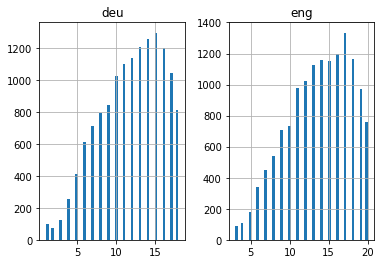

In [16]:
length_df.hist(bins = 50)
plt.show()

In [17]:
lines.sample(10)

,deu,en
9206,kein geldbetrag wird ausreichen um den zugefüg...,START_ no amount of money will undo the damage...
10440,anderswo in europa sind die tendenzen ähnlich,START_ the trends are similar elsewhere in eur...
3642,allerdings besteht der verdacht dass dies bei ...,START_ the suspicion though is that this is no...
1396,ein mächtiger präsident muss für die ukraine a...,START_ a powerful president however is not nec...
13888,aber der begriff ist verwirrend,START_ but the term is confusing _END
17418,infolge dieser entwicklung konnten die generäl...,START_ as a result myanmars generals have been...
4810,es gibt keinen grund warum das gleiche ergebni...,START_ there is no reason that the same outcom...
11535,die golfstaaten deren bürger nicht in libyen a...,START_ the gulf countries which have no citize...
11554,ich nenne das besonnenheit vielleicht sogar we...,START_ i call that prudence perhaps even wisdo...
16789,arbeitsplan,START_ work schedule _END


  ### Training Preparation.

In [0]:
# Vocabulary of English
all_en_words=set()
for en in lines.en:
    for word in en.split():
        if word not in all_en_words:
            all_en_words.add(word)

# Vocabulary of Deutsch 
all_deu_words=set()
for deu in lines.deu:
    for word in deu.split():
        if word not in all_deu_words:
            all_deu_words.add(word)

In [19]:
# Max Length of source sequence
max_length_src = np.max(eng_l)
max_length_src

20

In [20]:
# Max Length of target sequence
max_length_tar = np.max(deu_l) + 1
max_length_tar

19

In [21]:
input_words = sorted(list(all_deu_words))
target_words = sorted(list(all_en_words))
num_encoder_tokens = len(all_deu_words)
num_decoder_tokens = len(all_en_words)
num_encoder_tokens, num_decoder_tokens

(14617, 10003)

In [22]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

10004

In [23]:
print("Total Sentences EN : ",len(lines.en))
print("Total Sentences DEU : ",len(lines.deu))

Total Sentences EN :  14004
Total Sentences DEU :  14004


In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [25]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print(reverse_input_char_index)
print(reverse_target_char_index)

{1: 'a', 2: 'ab', 3: 'abba', 4: 'abbas', 5: 'abbau', 6: 'abbauen', 7: 'abbekommen', 8: 'abchasien', 9: 'abdrücken', 10: 'abduktiv', 11: 'abduktive', 12: 'abe', 13: 'abebben', 14: 'abends', 15: 'abenteuerlichen', 16: 'aber', 17: 'abfedernde', 18: 'abfedert', 19: 'abfederung', 20: 'abfederungalleineiner', 21: 'abfeuern', 22: 'abfließen', 23: 'abfluss', 24: 'abgaben', 25: 'abgang', 26: 'abgebaut', 27: 'abgeben', 28: 'abgefunden', 29: 'abgegeben', 30: 'abgehalten', 31: 'abgehoben', 32: 'abgeht', 33: 'abgelaufen', 34: 'abgelegenen', 35: 'abgelegt', 36: 'abgelehnt', 37: 'abgeleistet', 38: 'abgeleitet', 39: 'abgelenkt', 40: 'abgemacht', 41: 'abgeordnete', 42: 'abgerutscht', 43: 'abgeschafft', 44: 'abgeschlossen', 45: 'abgeschotteten', 46: 'abgeschworen', 47: 'abgesehen', 48: 'abgesichert', 49: 'abgestaubt', 50: 'abgestempelt', 51: 'abgestimmt', 52: 'abgestraft', 53: 'abgetan', 54: 'abgewehrt', 55: 'abgewickelt', 56: 'abgeändert', 57: 'abgibt', 58: 'abgleiten', 59: 'abgleitet', 60: 'abgrund', 

In [26]:
lines = shuffle(lines)
lines.head(10)

,deu,en
6447,krebs vorbeugende tomaten merkt euch das,START_ cancerpreventing tomatoes take notice _END
8617,und das ist nur das grundszenario,START_ and this is just the baseline scenario ...
5121,die führungsrolle china muss noch weitblickend...,START_ chinas leadership needs to be even more...
9178,die beste methode den klimawandel auf lange si...,START_ the best way to reduce longterm climate...
17034,cambridge man bemüht sich wieder einmal die we...,START_ cambridge efforts to make the world saf...
1673,die durchführung dessen nimmt einige zeit in a...,START_ this will take some time to implement _END
10920,um die dynamik des konfliktes in burundi zu ve...,START_ to understand the dynamics of conflict ...
6381,diese aufgabe erfordert geduld und strategisch...,START_ that task requires patience and strateg...
3168,verglichen mit den meisten anderen ländern wir...,START_ that number looks small compared to mos...
5847,dreißig jahre später wir haben ein déjà vu gel...,START_ thirty years later déjà vu the same mes...


In [27]:
# Train - Test Split
X, y = lines.deu, lines.en
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((12603,), (1401,))

### Batch Function

In [0]:
def generate_batch(X = X_train, y = y_train):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder-Decoder RNN 

In [29]:
latent_dim = 200

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_rnn = SimpleRNN(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_rnn(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_rnn = SimpleRNN(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_rnn(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

### Model Execution

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [32]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 384
epochs = 100
time_callback = TimeHistory()

history = model.fit_generator(generator = generate_batch(X_train, y_train),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs, 
                    callbacks=[time_callback],
                    validation_data = generate_batch(X_test, y_test),
                    validation_steps = val_samples//batch_size)
model.save_weights('rnn_weights.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
32/32 [==============================] - 14s 443ms/step - loss: 7.2314 - acc: 0.0642 - val_loss: 6.7843 - val_acc: 0.0887
Epoch 2/100
32/32 [==============================] - 10s 304ms/step - loss: 6.6627 - acc: 0.0967 - val_loss: 6.6204 - val_acc: 0.0978
Epoch 3/100
32/32 [==============================] - 10s 304ms/step - loss: 6.4505 - acc: 0.1058 - val_loss: 6.4415 - val_acc: 0.1181
Epoch 4/100
32/32 [==============================] - 10s 305ms/step - loss: 6.2606 - acc: 0.1240 - val_loss: 6.3061 - val_acc: 0.1374
Epoch 5/100
32/32 [==============================] - 10s 305ms/step - loss: 6.1165 - acc: 0.1372 - val_loss: 6.1976 - val_acc: 0.1437
Epoch 6/100
32/32 [==============================] - 10s 307ms/step - loss: 5.9543 - acc: 0.1459 - val_loss: 6.0807 - val_acc: 0.1471
Epoch 7/100
32/32 [==============================] - 10s 305ms/step - 

### Load the weights

In [0]:
model.load_weights('rnn_weights.h5')

### Inference Setup

In [34]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence
print(dec_emb2)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2 = decoder_rnn(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

Tensor("embedding_2_1/embedding_lookup/Identity:0", shape=(?, ?, 200), dtype=float32)


### Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = [encoder_model.predict(input_seq)]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0] = sampled_token_index

        # Update states
        states_value = [h]

    return decoded_sentence

#### Result and Evaluation on Train Dataset

In [0]:
batch_size=1

In [0]:
train_gen = generate_batch(X_train, y_train)

In [38]:
ref = []
can = []

for k in range(50):
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Deutch sentence:', X_train[k:k+1].values[0])
    print('Actual English Translation:', y_train[k:k+1].values[0][6:-4])
    ref.append([y_train[k:k+1].values[0][6:-4].split()])
    print('Predicted English Translation:', decoded_sentence[:-4])
    can.append(decoded_sentence[:-4].split())
    print("-----------------------------------------")
    
print(ref)
print(can)

Input Deutch sentence: doch heute stellt die afrikanische gepflogenheit direkt zu bezahlen einen leistungsstarken schutz vor einer finanziellen ansteckung dar
Actual English Translation:  but today africas payasyougo practices are a powerful defense against financial contagion 
Predicted English Translation:  but today africas payasyougo practices are a powe
-----------------------------------------
Input Deutch sentence: doch die kosten des protektionismus im handel und finanzwesen sind in momenten wie diesen besonders hoch
Actual English Translation:  but the costs of protectionism in trade and finance are especially large at moments like these 
Predicted English Translation:  but the costs of protectionism in trade and fin
-----------------------------------------
Input Deutch sentence: das sichert mäßigung und toleranz gleichermaßen wie reformfähigkeit
Actual English Translation:  moderation tolerance and a capacity for reform in equal measure are the watchwords of todays german co

In [39]:
score = corpus_bleu(ref, can)
print("BLEU Score LSTM : ", score)

BLEU Score LSTM :  0.5684917728585085


## MODEL EVALUATION

In [0]:
val_gen = generate_batch(X_test, y_test)

In [41]:
ref = []
can = []

for k in range(len(X_test)):
    (input_seq, actual_output), _ = next(val_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input Deutsch sentence:', X_test[k:k+1].values[0])
    print('Actual English Translation:', y_test[k:k+1].values[0][6:-4])
    ref.append([y_test[k:k+1].values[0][6:-4].split()])
    print('Predicted English Translation:', decoded_sentence[:-4])
    can.append(decoded_sentence[:-4].split())
    print("---------------------------------------------------------------------------------")


Input Deutsch sentence: im jahr betrug der anteil asiens am globalen bip  wovon etwas mehr als die hälfte auf china entfiel
Actual English Translation:  in  asias share of global gdp was  with china accounting for slightly more than half 
Predicted English Translation:  in asias share of global public initiatives in eu
---------------------------------------------------------------------------------
Input Deutsch sentence: dies ist eine riskante spekulation
Actual English Translation:  this is risky speculation 
Predicted English Translation:  this is risky speculation 
---------------------------------------------------------------------------------
Input Deutsch sentence: es ist immer wieder gesagt worden dass arafat ein zweifelhafter segen für sein volk war
Actual English Translation:  it has been correctly said over and again that arafat was a mixed blessing for his people 
Predicted English Translation:  it has been correctly said over years again tha
-----------------------------

## GRAPH AND COMPUTATION TIME

Total Computation Time :  981.1107285022736


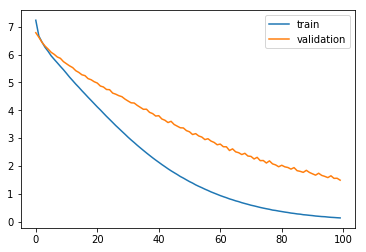

<Figure size 432x288 with 0 Axes>

In [42]:
print("Total Computation Time : ", sum(time_callback.times))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
fig = plt.figure()
plt.show()

In [44]:
score = corpus_bleu(ref, can)
print("BLEU Score RNN : ", score)

BLEU Score RNN :  0.4145619095236361
